# Naive Baeyes Algorithm
It is a very simple classificiation based on **Baeyes Theorem**.
Assumptions:
- ### IID:
It states that all the features which are used in classification are independent and identical from each other.
    - **Independent**: This means that each feature is purely independent of each other and one does not effect another.
    - **Identical**: This means that we are assuming that each of the feature is obtained from the same distribution , in this case Mullitvariate Gaussian.
#### Baeyes Theorem:
$$P(A|B) = \frac{P(B|A)P(A)}{P(B)}$$
For machine learning , naive baeyes can be written as :
$$P(class|data) = \frac{P(data|class)P(class)}{P(data)}$$
- P(class) : Prior Probability , it is the probability of class in the given dataset.
- P(data): Total probability 
- P(data|clas) : Likelihood Probability , probability of class having a given data value associated to it.
- P(class| data) : Posterior Probability , probability of data having a particular class

![](https://i.ytimg.com/vi/eho8xH3E6mE/hqdefault.jpg)

In [10]:
from utils_naive_baeyes import process_tweet, lookup
import pdb
from nltk.corpus import stopwords, twitter_samples
import numpy as np
import pandas as pd
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly as py
import nltk
import string
from nltk.tokenize import TweetTokenizer
from os import getcwd

In [11]:
# add folder, tmp2, from our local workspace containing pre-downloaded corpora files to nltk's data path
filePath = f"{getcwd()}/../tmp2/"
nltk.data.path.append(filePath)

In [12]:
# get the sets of positive and negative tweets
all_positive_tweets = twitter_samples.strings('positive_tweets.json')
all_negative_tweets = twitter_samples.strings('negative_tweets.json')

# split the data into two pieces, one for training and one for testing (validation set)
test_pos = all_positive_tweets[4000:]
train_pos = all_positive_tweets[:4000]
test_neg = all_negative_tweets[4000:]
train_neg = all_negative_tweets[:4000]

train_x = train_pos + train_neg
test_x = test_pos + test_neg


train_y = np.append(np.ones(len(train_pos)), np.zeros(len(train_neg)))
test_y = np.append(np.ones(len(test_pos)), np.zeros(len(test_neg)))

# Process the Data

In [13]:
custom_tweet = "RT @Twitter @chapagain Hello There! Have a great day. :) #good #morning http://chapagain.com.np"

# print cleaned tweet
print(process_tweet(custom_tweet))

['hello', 'great', 'day', ':)', 'good', 'morn']


In [14]:
def count_tweets(result, tweets, ys):
    '''
    Input:
        result: a dictionary that will be used to map each pair to its frequency
        tweets: a list of tweets
        ys: a list corresponding to the sentiment of each tweet (either 0 or 1)
    Output:
        result: a dictionary mapping each pair to its frequency
    '''
    for y,tweet in zip(ys,tweets):
        for word in process_tweet(tweet):
            pair = (word,y)
            if pair in result:
                result[pair]+=1
            else:
                result[pair] = 1
    return result

In [15]:
result = {}
tweets = ['i am happy', 'i am tricked', 'i am sad', 'i am tired', 'i am tired']
ys = [1, 0, 0, 0, 0]
count_tweets(result, tweets, ys)

{('happi', 1): 1, ('trick', 0): 1, ('sad', 0): 1, ('tire', 0): 2}

In [16]:
freqs = count_tweets({}, train_x, train_y)

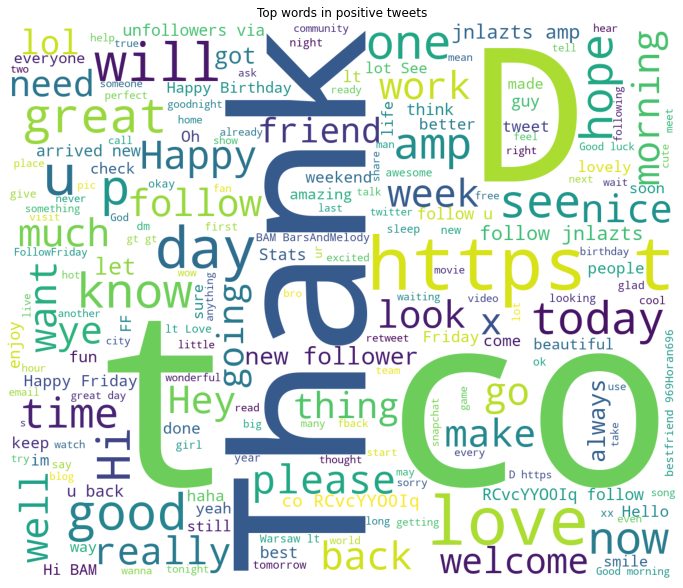

In [18]:
plt.figure(figsize = (12, 12))
text = ' '.join(all_positive_tweets)
wordcloud = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top words in positive tweets')
plt.axis("off")
plt.show()

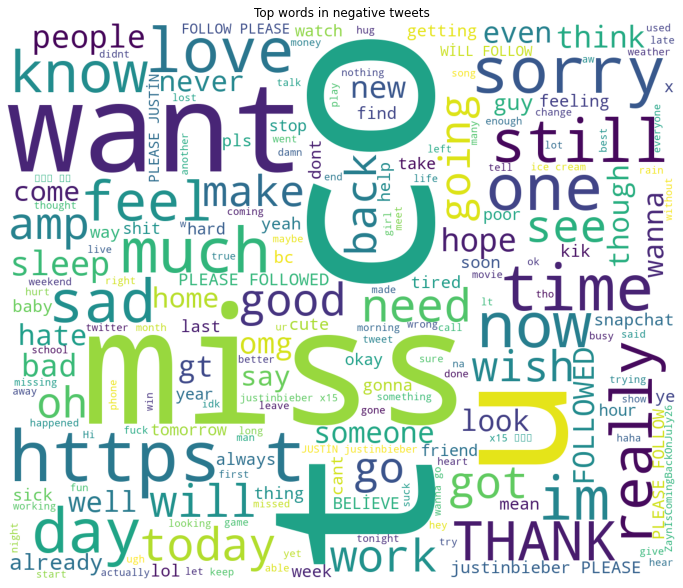

In [19]:
plt.figure(figsize = (12, 12))
text = ' '.join(all_negative_tweets)
wordcloud = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top words in negative tweets')
plt.axis("off")
plt.show()

# Why use log likelihood probability??
In this type of data where each value is categorical and using any pdf is impossible then we use \
 the probabilities calculated and use them instead to calculate Likelihood Probability. \
**BUT**\
Multiplying so many values will reach beyond the capability of python(lowest value possible is of 10^(-36) so we will calculate the probabilties by converting them into **Negative Log Probability** .


The prior probability represents the underlying probability in the target population that a tweet is positive versus negative.  In other words, if we had no specific information and blindly picked a tweet out of the population set, what is the probability that it will be positive versus that it will be negative? That is the "prior".
The prior is the ratio of the probabilities :
$\frac{P(D_{pos})}{P(D_{neg})}$.
$$\text{logprior} = log \left( \frac{P(D_{pos})}{P(D_{neg})} \right) = log \left( \frac{D_{pos}}{D_{neg}} \right)$$


Positive Probability and negative probability for each word
$$ P(W_{pos}) = \frac{freq_{pos} + 1}{N_{pos} + V} $$
$$ P(W_{neg}) = \frac{freq_{neg} + 1}{N_{neg} + V}$$
Log Likeli hood :
$$log \left( \frac{P(W_{pos})}{P(W_{neg})} \right)$$.

In [12]:
def train_naive_bayes(freqs, train_x, train_y):
    '''
    Input:
        freqs: dictionary from (word, label) to how often the word appears
        train_x: a list of tweets
        train_y: a list of labels correponding to the tweets (0,1)
    Output:
        logprior: the log prior. (equation 3 above)
        loglikelihood: the log likelihood of you Naive bayes equation. (equation 6 above)
    '''
    loglikelihood = {}
    logprior = 0
    
    vocab = set([pair[0] for pair in freqs.keys()])
    V = len(vocab)
    
    N_pos=N_neg = 0
    for pair in freqs.keys():
        if pair[1] >0:
            N_pos+= freqs[pair]
        else:
            N_neg+= freqs[pair]
    D = len(train_y)
    D_pos = sum(i==1 for i in train_y)
    D_neg = D - D_pos
    
    # logprior 
    logprior = np.log(D_pos/D) - np.log(D_neg/D)
    
    for word in vocab:
        freq_pos = lookup(freqs,word,1)
        freq_neg = lookup(freqs,word,0)
        
        # calculate the probability that each word is positive, and negative
        p_w_positive = (freq_pos+1)/(N_pos + V)
        p_w_negative = (freq_neg + 1)/(N_neg + V)
        
        loglikelihood[word] = np.log(p_w_positive) - np.log(p_w_negative)
    return logprior, loglikelihood

In [13]:
logprior, loglikelihood = train_naive_bayes(freqs, train_x, train_y)
print(logprior)
print(len(loglikelihood))

0.0
9085


# Prediciting the porbability
Probability will be calculated by adding logprior and loglikelihood probability. 
$$ p = logprior + \sum_i^N (loglikelihood_i)$$

In [14]:
def naive_bayes_predict(tweet, logprior, loglikelihood):
    '''
    Input:
        tweet: a string
        logprior: a number
        loglikelihood: a dictionary of words mapping to numbers
    Output:
        p: the sum of all the logliklihoods of each word in the tweet (if found in the dictionary) + logprior (a number)

    '''
    words = process_tweet(tweet)
    
    p = 0
    p+=logprior
    
    for word in words:
        if word in loglikelihood:
            p+=loglikelihood[word]
    return p

In [15]:
my_tweet = 'She smiled.'
p = naive_bayes_predict(my_tweet, logprior, loglikelihood)
print('The expected output is', p)

The expected output is 1.5737794405738939


## Testing the algorithm 
- In this we will simply calculate the value of probability and then compare if it is greater than 0 then it assigned class '1' otherwise class '0'.
- Then simply subtracting it by test_y and getting the mean absolute value for this error and subtracting this error from 1 to get our accuracy.

In [35]:
def test_naive_bayes(test_x, test_y, logprior, loglikelihood):
    """
    Input:
        test_x: A list of tweets
        test_y: the corresponding labels for the list of tweets
        logprior: the logprior
        loglikelihood: a dictionary with the loglikelihoods for each word
    Output:
        accuracy: (# of tweets classified correctly)/(total # of tweets)
    """
    accuracy = 0
    
    y_hats = []
    
    for tweet in test_x:
        if naive_bayes_predict(tweet,logprior,loglikelihood) > 0:
            y_hat_i = 1
        else:
            y_hat_i = 0
        y_hats.append(y_hat_i)
        
    error = np.mean(np.absolute(y_hats - test_y))
    
    accuracy = 1 - error
    
    return accuracy

In [21]:
print("Naive Bayes accuracy = %0.4f" %
      (test_naive_bayes(test_x, test_y, logprior, loglikelihood)))

Naive Bayes accuracy = 0.9940


In [36]:
for tweet in ['I am happy', 'I am bad', 'this movie should have been great.', 'great', 'great great', 'great great great', 'great great great great']:
    p = naive_bayes_predict(tweet, logprior, loglikelihood)
    print(f'{tweet} -> {p:.2f}')

I am happy -> 2.15
I am bad -> -1.29
this movie should have been great. -> 2.14
great -> 2.14
great great -> 4.28
great great great -> 6.41
great great great great -> 8.55


In [24]:
my_tweet = 'you are bad :('
naive_bayes_predict(my_tweet, logprior, loglikelihood)

-8.802119484044239

## Comparing the ratio
- Sometimes there are words which have greater impact on deciding the class of the tweet,the so called 'power words'.
- To get these power words we will calculate the ratio and also compare them with some threshold afterwards.
$$ ratio = \frac{\text{pos_words} + 1}{\text{neg_words} + 1} $$

In [37]:
def get_ratio(freqs,word):
    '''
    Input:
        freqs: dictionary containing the words
        word: string to lookup

    Output: a dictionary with keys 'positive', 'negative', and 'ratio'.
        Example: {'positive': 10, 'negative': 20, 'ratio': 0.5}
    '''
    pos_neg_ratio = {'positive':0 , 'negative':0 ,'ratio':0.0}
    pos_neg_ratio['positive'] = lookup(freqs,word,1)
    pos_neg_ratio['negative'] = lookup(freqs,word,0)
    
    pos_neg_ratio['ratio'] = (pos_neg_ratio['positive'] + 1)/(pos_neg_ratio['negative'] + 1)
    
    return pos_neg_ratio

In [38]:
get_ratio(freqs, 'happi')

{'positive': 161, 'negative': 18, 'ratio': 8.526315789473685}

In [39]:
def get_words_by_threshold(freqs, label, threshold):
    '''
    Input:
        freqs: dictionary of words
        label: 1 for positive, 0 for negative
        threshold: ratio that will be used as the cutoff for including a word in the returned dictionary
    Output:
        word_set: dictionary containing the word and information on its positive count, negative count, and ratio of positive to negative counts.
        example of a key value pair:
        {'happi':
            {'positive': 10, 'negative': 20, 'ratio': 0.5}
        }
    '''
    word_list = {}
    
    for key in freqs.keys():
        word,_ = key
        
        pos_neg_ratio = get_ratio(freqs,word)
        
        if label == 1 and pos_neg_ratio['ratio']>=threshold:
            word_list[word] = pos_neg_ratio
        elif label == 0 and pos_neg_ratio['ratio']<=threshold:
            word_list[word] = pos_neg_ratio
    return word_list


In [40]:
get_words_by_threshold(freqs, label=0, threshold=0.05)

{':(': {'positive': 1, 'negative': 3663, 'ratio': 0.0005458515283842794},
 ':-(': {'positive': 0, 'negative': 378, 'ratio': 0.002638522427440633},
 'zayniscomingbackonjuli': {'positive': 0, 'negative': 19, 'ratio': 0.05},
 '26': {'positive': 0, 'negative': 20, 'ratio': 0.047619047619047616},
 '>:(': {'positive': 0, 'negative': 43, 'ratio': 0.022727272727272728},
 'lost': {'positive': 0, 'negative': 19, 'ratio': 0.05},
 '♛': {'positive': 0, 'negative': 210, 'ratio': 0.004739336492890996},
 '》': {'positive': 0, 'negative': 210, 'ratio': 0.004739336492890996},
 'beli̇ev': {'positive': 0, 'negative': 35, 'ratio': 0.027777777777777776},
 'wi̇ll': {'positive': 0, 'negative': 35, 'ratio': 0.027777777777777776},
 'justi̇n': {'positive': 0, 'negative': 35, 'ratio': 0.027777777777777776},
 'ｓｅｅ': {'positive': 0, 'negative': 35, 'ratio': 0.027777777777777776},
 'ｍｅ': {'positive': 0, 'negative': 35, 'ratio': 0.027777777777777776}}

In [41]:
get_words_by_threshold(freqs, label=1, threshold=10)

{'followfriday': {'positive': 23, 'negative': 0, 'ratio': 24.0},
 'commun': {'positive': 27, 'negative': 1, 'ratio': 14.0},
 ':)': {'positive': 2847, 'negative': 2, 'ratio': 949.3333333333334},
 'flipkartfashionfriday': {'positive': 16, 'negative': 0, 'ratio': 17.0},
 ':D': {'positive': 498, 'negative': 0, 'ratio': 499.0},
 ':p': {'positive': 103, 'negative': 0, 'ratio': 104.0},
 'influenc': {'positive': 16, 'negative': 0, 'ratio': 17.0},
 ':-)': {'positive': 543, 'negative': 0, 'ratio': 544.0},
 "here'": {'positive': 20, 'negative': 0, 'ratio': 21.0},
 'youth': {'positive': 14, 'negative': 0, 'ratio': 15.0},
 'bam': {'positive': 44, 'negative': 0, 'ratio': 45.0},
 'warsaw': {'positive': 44, 'negative': 0, 'ratio': 45.0},
 'shout': {'positive': 11, 'negative': 0, 'ratio': 12.0},
 ';)': {'positive': 22, 'negative': 0, 'ratio': 23.0},
 'stat': {'positive': 51, 'negative': 0, 'ratio': 52.0},
 'arriv': {'positive': 57, 'negative': 4, 'ratio': 11.6},
 'via': {'positive': 60, 'negative': 1, 

In [44]:
# It is a positive sentiment as it is true 😉
my_tweet = 'Dc is better than marvels'

p = naive_bayes_predict(my_tweet, logprior, loglikelihood)
print(p)

0.6636283173328446
